In [62]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


In [63]:

global dt
global psi
global c
global v
global n
global k
global radius
global rho_o
global control_signal
global control_hold
global control_rate
control_time_delay = 2

control_hold = 0
dt = 0.01
control_rate = int(control_time_delay/dt)
c = 1.1
psi = np.pi*(3.01/2)

v = 0.2
n = 1
k = 0.1
radius = 0.6
lambda_v = np.exp((2*v)/(k*radius*np.pi))
rho_o = ((c-1)*radius)/((lambda_v*c) - 1)
control_signal = []


Dynamics :

$\dot{x}(t) = v\cos \theta (t)\\$
$\dot{y}(t) = v\sin \theta (t)\\$
$\dot{theta}(t) = u(t)\\$

Control Law for one vehicle : 

$$
    u(t)= 
\begin{cases}
    k \cdot g(\rho (t) ; c,\rho_0) \cdot \alpha_d(\gamma(t)) ,& \text{if } \rho(t) > 0\\
    0,              & \text{if } \rho(t) = 0
\end{cases} \\
$$
with
$$
g(\rho ; c,\rho_0) = ln\Big (\frac{(c-1)\cdot \rho + \rho_0}{c \cdot \rho_0}\Big )\\
$$

$$
\alpha_d(\gamma) = \begin{cases}
    \gamma ,& \text{if } 0 \leq \gamma \leq \psi\\
    \gamma - 2 \pi,              & \text{if } \psi < \gamma \leq 2 \pi
\end{cases} \\
$$

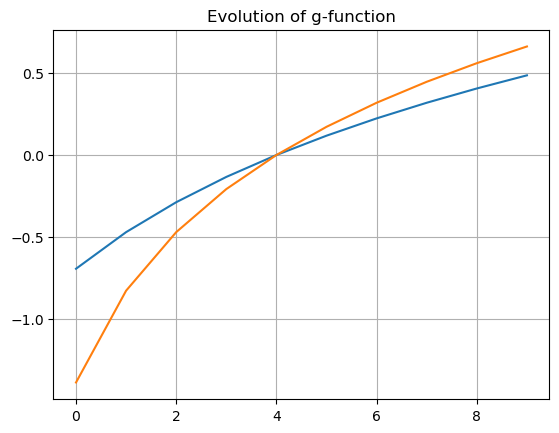

In [64]:
op1 = []
op2 = []
var_0 = 4
var_c1 = 2
var_c2 = 4
for var in range(10):
    op1.append(np.log((((var_c1-1)*var) + var_0)/(var_c1*var_0)))
    op2.append(np.log((((var_c2-1)*var) + var_0)/(var_c2*var_0)))
plt.plot(op1)
plt.plot(op2)

plt.title("Evolution of g-function")
plt.grid(True)
plt.show()


In [65]:

def g_function(xb,xv,c,rho_o):
    rho_v = np.array(xb) - np.array(xv)
    rho = np.linalg.norm(rho_v)
    g = np.log((((c-1)*rho) + rho_o)/(c*rho_o))
    if (rho<0.000000001):
        g = 0
    return g
def alpha_d(gamma,psi):
    if ((gamma>=0)and (gamma <=psi)):
        return gamma
    elif ((gamma>psi)and (gamma <2*np.pi)):
        return gamma - 2*np.pi
    else :
        print("Error in gamma value" + gamma)

def u_t(xv,xb,heading):
    gamma = get_angle(xb[0] - xv[0],xb[1] - xv[1]) - heading
    while (gamma>2*np.pi):
        gamma = gamma -2*np.pi
    while (gamma<0):
        gamma = gamma + 2*np.pi
    #print(np.rad2deg(gamma))
    alpha = alpha_d(gamma,psi)

    g = g_function(xb,xv,c,rho_o)
    
    u = k*g*alpha
    control_signal.append(u)
    return np.array([u])

def velocity(t,n):
    return np.ones(n)*v
def adjust_angle(x,n):
    for i in range (n):
        while (x[(3*i)+2]>2*np.pi):
            x[(3*i)+2] = x[(3*i)+2] -2*np.pi
        while (x[(3*i)+2]<0):
            x[(3*i)+2] = x[(3*i)+2] + 2*np.pi


    return x

def f_unicycle(t,x,n):
    xb = np.array([-0.7 , 0.7])
    v_vec = velocity(t,n)
    global control_hold
    # print(int(t/dt)%control_rate)
    if int(t/dt)%control_rate == 0 :
        theta_dot_vec = u_t(x[0:2],xb,x[2])
        control_hold = theta_dot_vec
    else:
        theta_dot_vec = control_hold
    rhs = []
    for i in range(n):
        v = v_vec[i]
        theta_dot = theta_dot_vec[i]
        theta = x[(3*i) + 2]
        rhs.append([(v*np.cos(theta)),(v*np.sin(theta)),(theta_dot)])

    rhs = np.array(rhs)
    rhs = rhs.flatten()
    return rhs
def rk4_step(f,x,t,dt,n):
    k1 = f(t,x,n)
    k2 = f(t + (0.5*dt),x + (0.5*k1*dt),n)
    k3 = f(t + (0.5*dt),x + (0.5*k2*dt),n)
    k4 = f(t + dt,x + (k3*dt),n)

    return dt*((k1 + (2*k2) + (2*k3) + k4)/6)


def get_angle(dx,dy):
    theta = np.arctan2(dy,dx)
    if(theta<0):
        theta = theta + 2*np.pi
    return theta





In [66]:
# x0 = np.array([0,0,0,
#                5,0,np.pi/2,
#                5,5,np.pi,
#                0,5,3*np.pi/2])

# x0 = np.array([0,0,0,
#                5,0,0.2,
#                3,7,0.3,
#                -2,8,0.4])

# x0 = np.array([2,0,1.57])
x0 = np.array([0,0,1.57])
n = 1
traj = [x0]
x = x0
t = 0
T = 200
for i in tqdm(range(int(T/dt) )):
    dx = rk4_step(f_unicycle,x,t,dt,n)
    x = x + dx
    x = adjust_angle(x,n)
    t = t + dt
    traj.append(x)



100%|██████████| 20000/20000 [00:01<00:00, 11235.73it/s]


Velocity :  0.2


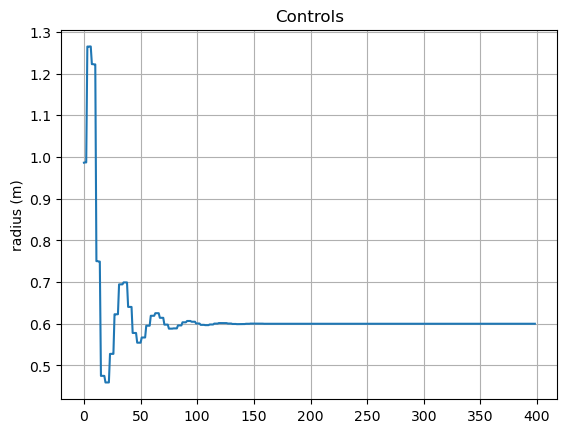

In [67]:
print("Velocity : ", v)
plt.plot(v/np.array(control_signal))
plt.title("Controls")
plt.grid(True)
plt.ylabel("radius (m)")
plt.show()

Velocity :  0.2


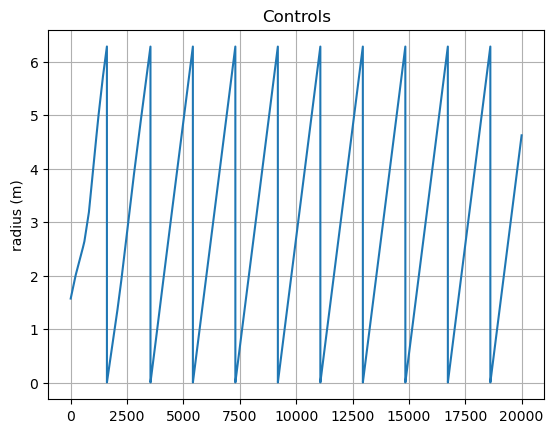

In [68]:
print("Velocity : ", v)
plt.plot(np.array(traj)[:,2])
plt.title("Controls")
plt.grid(True)
plt.ylabel("radius (m)")
plt.show()

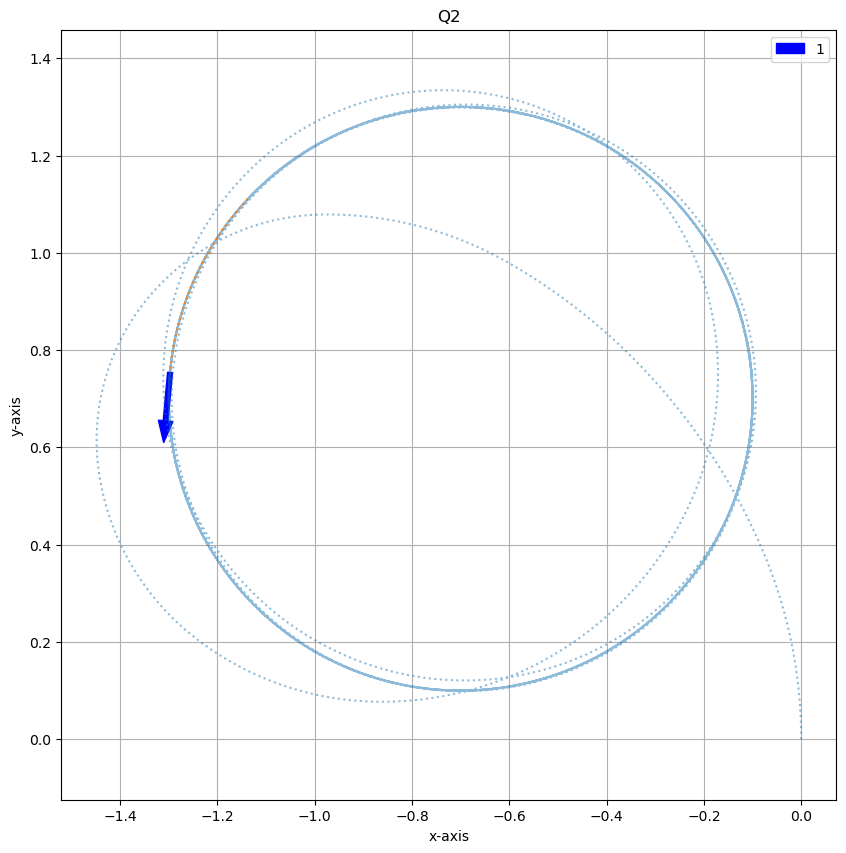

In [69]:
plt.figure(figsize=(10,10))
# plt.plot(np.array(traj)[:,0],np.array(traj)[:,1])
# plt.plot(np.array(traj)[:,2],np.array(traj)[:,3])
# plt.plot(np.array(traj)[:,4],np.array(traj)[:,5])
# plt.plot(np.array(traj)[:,6],np.array(traj)[:,7])
# plt.axis('equal')
# plt.show()

plt.plot(np.array(traj)[0:-200,0],np.array(traj)[0:-200,1],':',alpha = 0.5)
# plt.plot(np.array(traj)[0:-200,3],np.array(traj)[0:-200,4],'-.',alpha = 0.2)
# plt.plot(np.array(traj)[0:-200:,6],np.array(traj)[0:-200,7],'--',alpha = 0.2)
# plt.plot(np.array(traj)[0:-200,9],np.array(traj)[0:-200,10],alpha = 0.2)

plt.plot(np.array(traj)[-200:-1,0],np.array(traj)[-200:-1,1],':',alpha = 1)
# plt.plot(np.array(traj)[-200:-1,3],np.array(traj)[-200:-1,4],'-.',alpha = 1)
# plt.plot(np.array(traj)[-200:-1,6],np.array(traj)[-200:-1,7],'--',alpha = 1)
# plt.plot(np.array(traj)[-200:-1,9],np.array(traj)[-200:-1,10],alpha = 1)
plt.axis('equal')
plt.title('Q2')
plt.xlabel('x-axis')
plt.ylabel('y-axis')

plt.arrow(np.array(traj)[-1,0],np.array(traj)[-1,1],0.1*np.cos(np.array(traj)[-1,2]),0.1*np.sin(np.array(traj)[-1,2]),width=.01,label = '1',color = 'b')
# plt.arrow(np.array(traj)[-1,3],np.array(traj)[-1,4],np.cos(np.array(traj)[-1,5]),np.sin(np.array(traj)[-1,5]),width=.02,label = '2',color = 'r')
# plt.arrow(np.array(traj)[-1,6],np.array(traj)[-1,7],np.cos(np.array(traj)[-1,8]),np.sin(np.array(traj)[-1,8]),width=.02,label = '3',color = 'g')
# plt.arrow(np.array(traj)[-1,9],np.array(traj)[-1,10],np.cos(np.array(traj)[-1,11]),np.sin(np.array(traj)[-1,11]),width=.02,label = '4',color = 'y')
plt.legend()
plt.grid()
plt.show()


In [70]:
np.save("gt.npy",traj)